# Pipeline for Analyzing Asters

Today we will extract ATP gradients from an aster dataset. Executing the next few cells will import all the relevant data.

## Imports

In [26]:
# # Packages to locally download data into the notebook:
# import requests
# import zipfile
import glob

#Numpy
import numpy as np

#For image plotting
import skimage.io

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

#Movie plotting


#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#for image registration
from skimage.registration import phase_cross_correlation
import os

# For loading bars
from tqdm.notebook import tqdm as tqdm
import aster_packages

from PIL import Image

## Importing plotting

In [27]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 8
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
mpl.rc("figure", dpi=200)

In [28]:
import celluloid as cell
import matplotlib.animation as animation

## Initializing Images

In [29]:
# Converts List of image file paths to array of Images
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

### Specifying files

In [30]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/aster'
file_folder = '2022-07-29_Squaster_NCD_Venus_R3_1'

# #Choose the position(s)/aster(s) of interest:
pos_list = ['Pos0','Pos1','Pos2']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['YFP', 'Bright', 'CFP']

#included frames
included_frames = '*2022*.tif'

### Creating image arrays

Comment this section out if your tiff stack is abnormal. 

In [31]:
# Import images
for pos in pos_list:
    for channel in channel_list:

        #creates an empty list with the naming convention
        exec('im_files' + channel + pos + '= []')
        im_files = eval('im_files' + channel + pos)
        
        #appends all the file names
        im_files.append(
            np.sort(
                glob.glob(file_path + '/' + file_folder + '/' + pos + '/' + channel + '/' +
                          included_frames)))

        #Reads the files as images
        exec('im_array' + channel + pos + ' = file_to_image(im_files[0])')
        print('im_array' + channel + pos)

im_arrayYFPPos0
im_arrayBrightPos0
im_arrayCFPPos0
im_arrayYFPPos1
im_arrayBrightPos1
im_arrayCFPPos1
im_arrayYFPPos2
im_arrayBrightPos2
im_arrayCFPPos2


In [33]:
im_arrayYFPPos0 = np.abs(im_arrayYFPPos0)
im_arrayBrightPos0 = np.abs(im_arrayBrightPos0)
im_arrayCFPPos0 = np.abs(im_arrayCFPPos0)
im_arrayYFPPos1 = np.abs(im_arrayYFPPos1)
im_arrayBrightPos1 = np.abs(im_arrayBrightPos1)
im_arrayCFPPos1 = np.abs(im_arrayCFPPos1)
im_arrayYFPPos2 = np.abs(im_arrayYFPPos2)
im_arrayBrightPos2 = np.abs(im_arrayBrightPos2)
im_arrayCFPPos2 = np.abs(im_arrayCFPPos2)

### Reading bg images

In [34]:
#Choose the dark ims file name(located in folder 'Asters'):
file_path = '../../data/dark'

im_Bright_dark = skimage.io.imread(
    file_path + '/' + '*C1*.ome.tif'
).astype(np.int16)

im_YFP_dark = skimage.io.imread(
    file_path + '/' + '*C2*.ome.tif'
).astype(np.int16)

im_CFP_dark = skimage.io.imread(
    file_path + '/' + '*C3*.ome.tif'
).astype(np.int16)

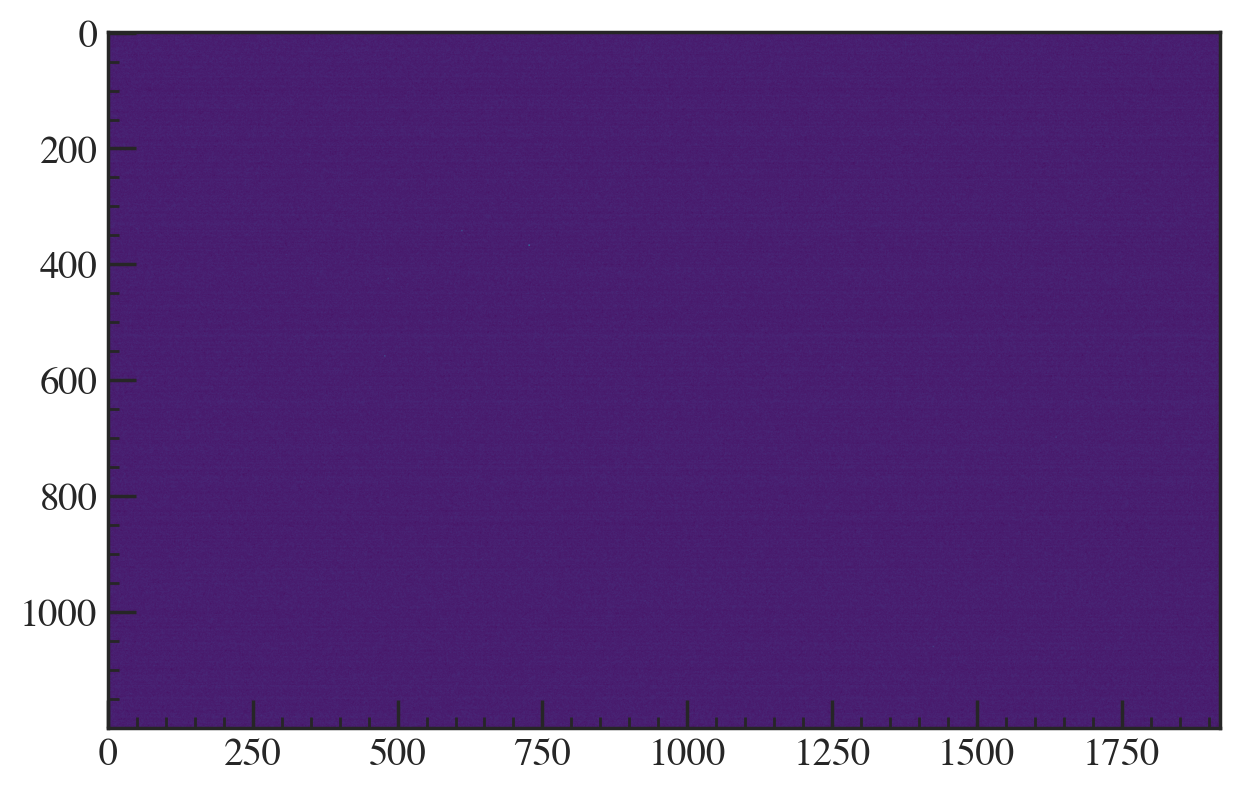

In [35]:
plt.imshow(im_YFP_dark)

### Param calibration

In [36]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59

#Image dims
w_px, h_px = 1920, 1200  #pixels
w_um, h_um = w_px * um_per_pixel, h_px * um_per_pixel  # microns

#Fontsize
f_small, f_big = 13, 15

array([[ 24832,  26640,  27280,  27792,  29696,  32608,  30928,  30480,
         30256,  29584,  29504,  30608,  31360,  32192,  32416,  32544,
         32480,  32288,  31120,  28896,  27680,  26368,  25568,  25040,
         24368,  23744,  22912,  22096,  21216,  20288],
       [ 25680,  27920,  29040,  29712,  31184,  31488,  30048,  30000,
         29280,  29120,  28912,  29344,  29616,  30288,  30752,  31200,
         31920,  32480,  31200,  29824,  28016,  27328,  26608,  26096,
         25536,  24752,  24080,  23344,  22496,  21872],
       [ 26656,  28816,  30528,  31264,  32400,  31168,  29440,  28944,
         28336,  28480,  28432,  27984,  28144,  29072,  29968,  30624,
         31440,  32272,  32064,  30736,  28944,  28160,  27488,  27056,
         26512,  25888,  25216,  24816,  24624,  24288],
       [ 27728,  29616,  31552,  32560,  31824,  30624,  29152,  28416,
         27744,  27760,  27568,  26432,  26288,  28592,  29936,  30800,
         31200,  31440,  32480,  3164

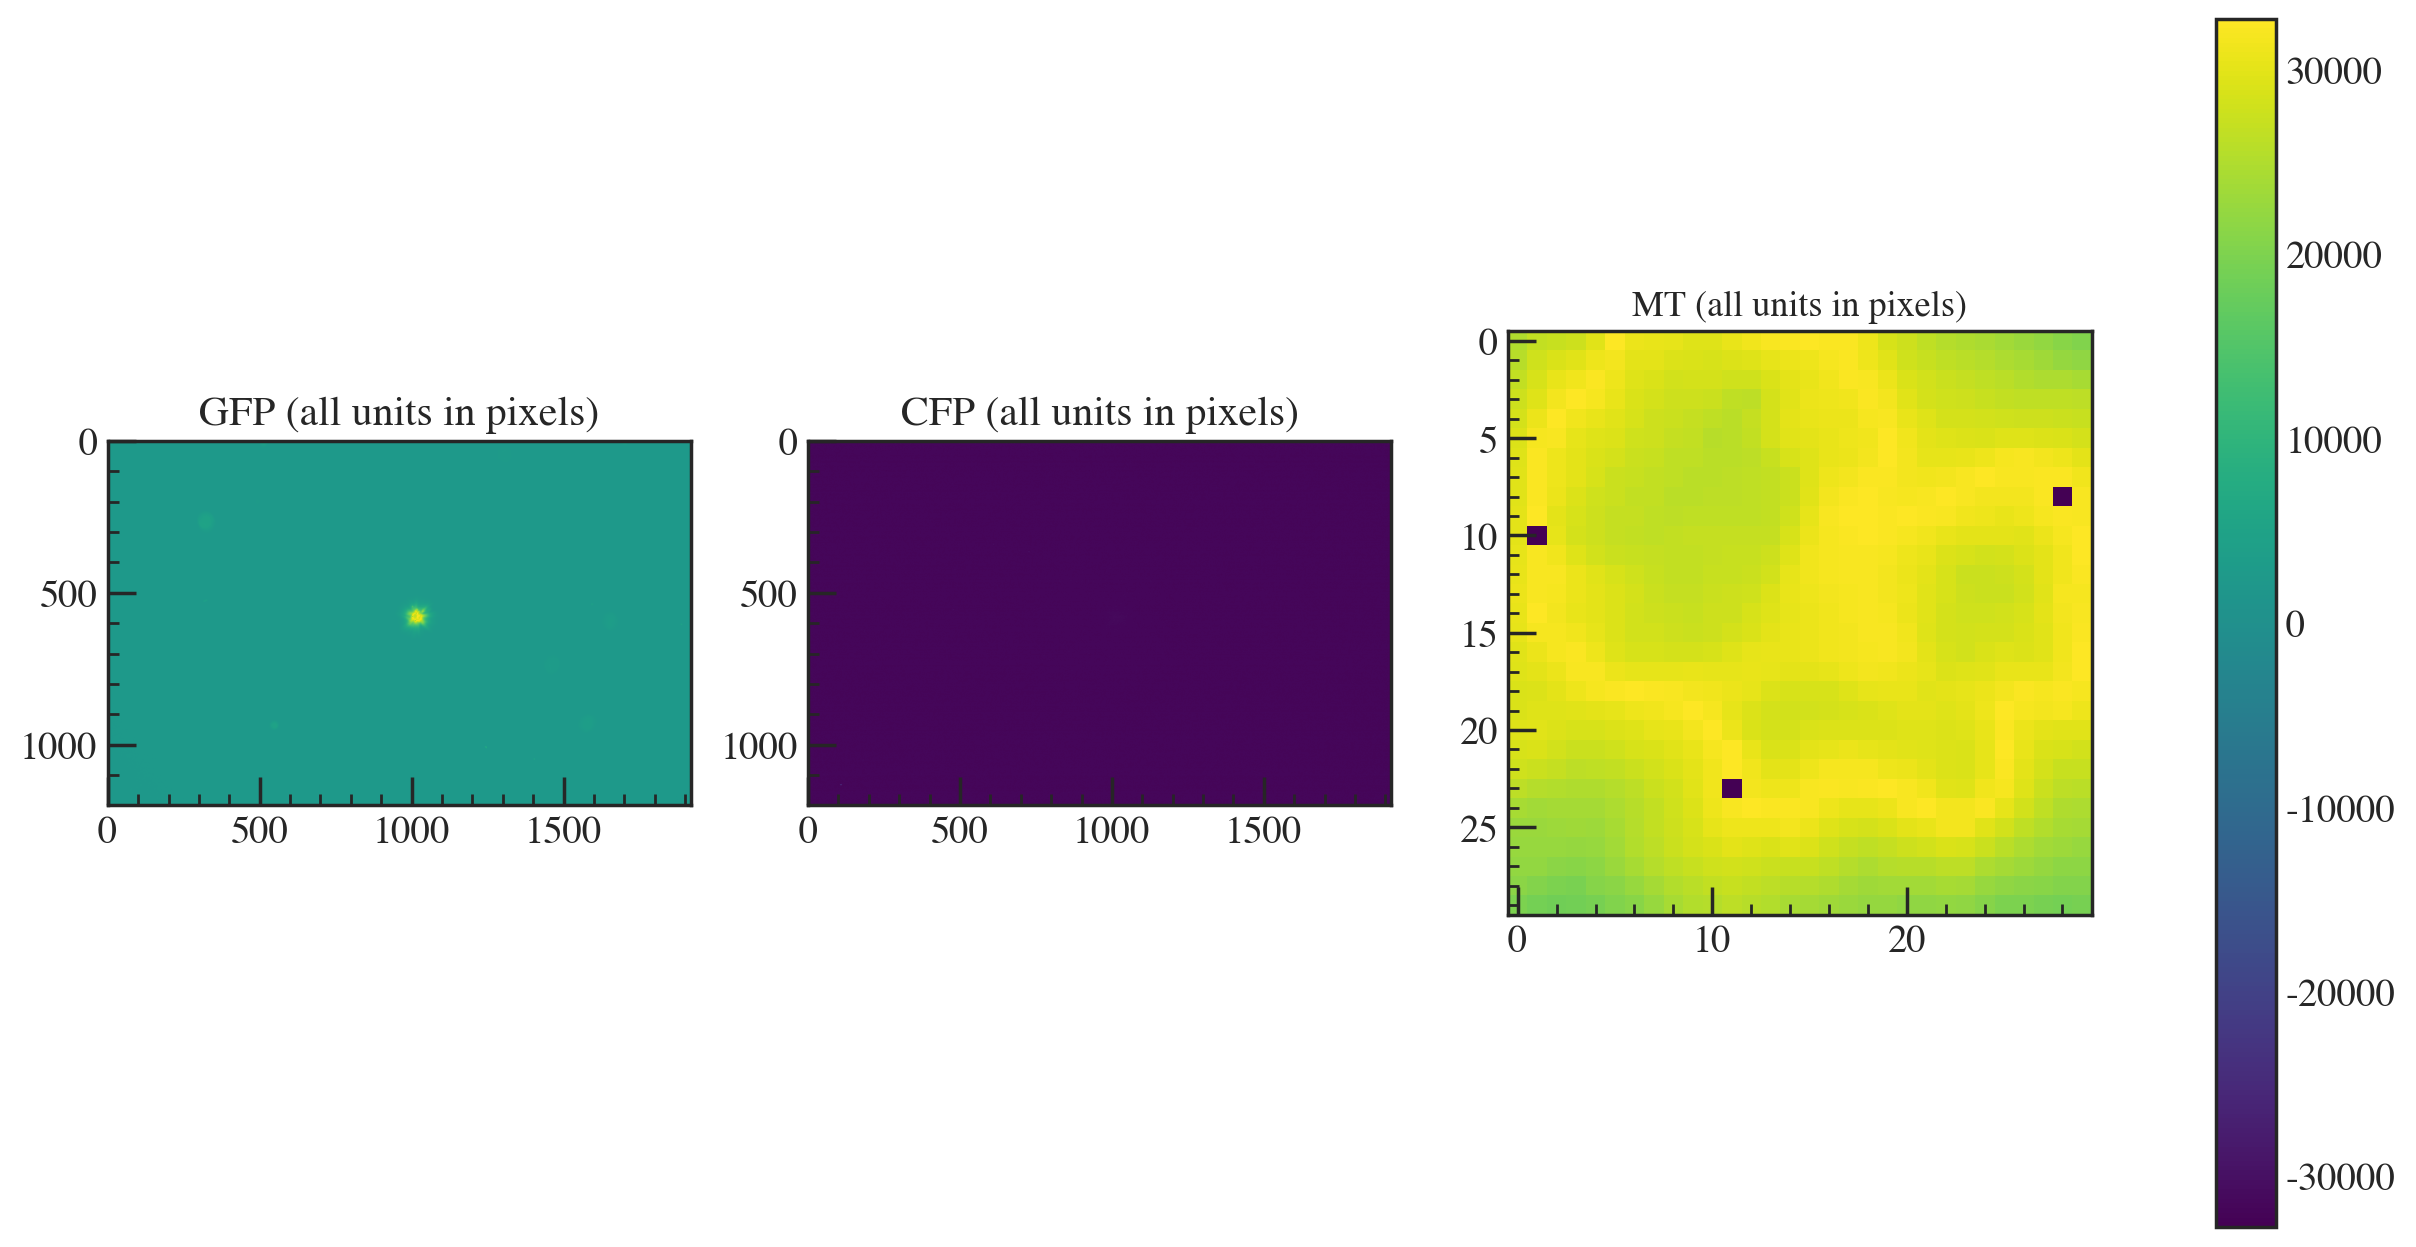

In [37]:
frame = 99
im_Bright = im_arrayBrightPos0[frame]
im_CFP = im_arrayCFPPos0[frame]
im_YFP = im_arrayYFPPos0[frame]

#define colorbar max and min
colorbar_max = np.percentile(im_YFP, 100)
colorbar_min = np.percentile(im_YFP, 0)

#define plot
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)

#define each subplot

ax[0].imshow(im_YFP)
ax[0].set_title('GFP (all units in pixels)', fontsize=f_big)

ax[1].imshow(im_CFP)
ax[1].set_title('CFP (all units in pixels)', fontsize=f_big)

#subplots: setting bg plots
ax[2].imshow(im_Bright)
ax[2].set_title('MT (all units in pixels)', fontsize=f_small)

fig.colorbar(cb_setting, ax=ax.ravel().tolist())

plt.imshow(im_YFP[570:600,1000:1030])
im_YFP[570:600,1000:1030]

### Subtracting bg image

In [38]:
# subtracting bg image from microtubule channel

im_arrayBrightPos0_bs = im_arrayBrightPos0 - im_Bright_dark
im_arrayYFPPos0_bs = im_arrayYFPPos0 - im_YFP_dark
im_arrayCFPPos0_bs = im_arrayCFPPos0 - im_CFP_dark

im_arrayBrightPos1_bs = im_arrayBrightPos1 - im_Bright_dark
im_arrayYFPPos1_bs = im_arrayYFPPos1 - im_YFP_dark
im_arrayCFPPos1_bs = im_arrayCFPPos1 - im_CFP_dark

im_arrayBrightPos2_bs = im_arrayBrightPos2 - im_Bright_dark
im_arrayYFPPos2_bs = im_arrayYFPPos2 - im_YFP_dark
im_arrayCFPPos2_bs = im_arrayCFPPos2 - im_CFP_dark

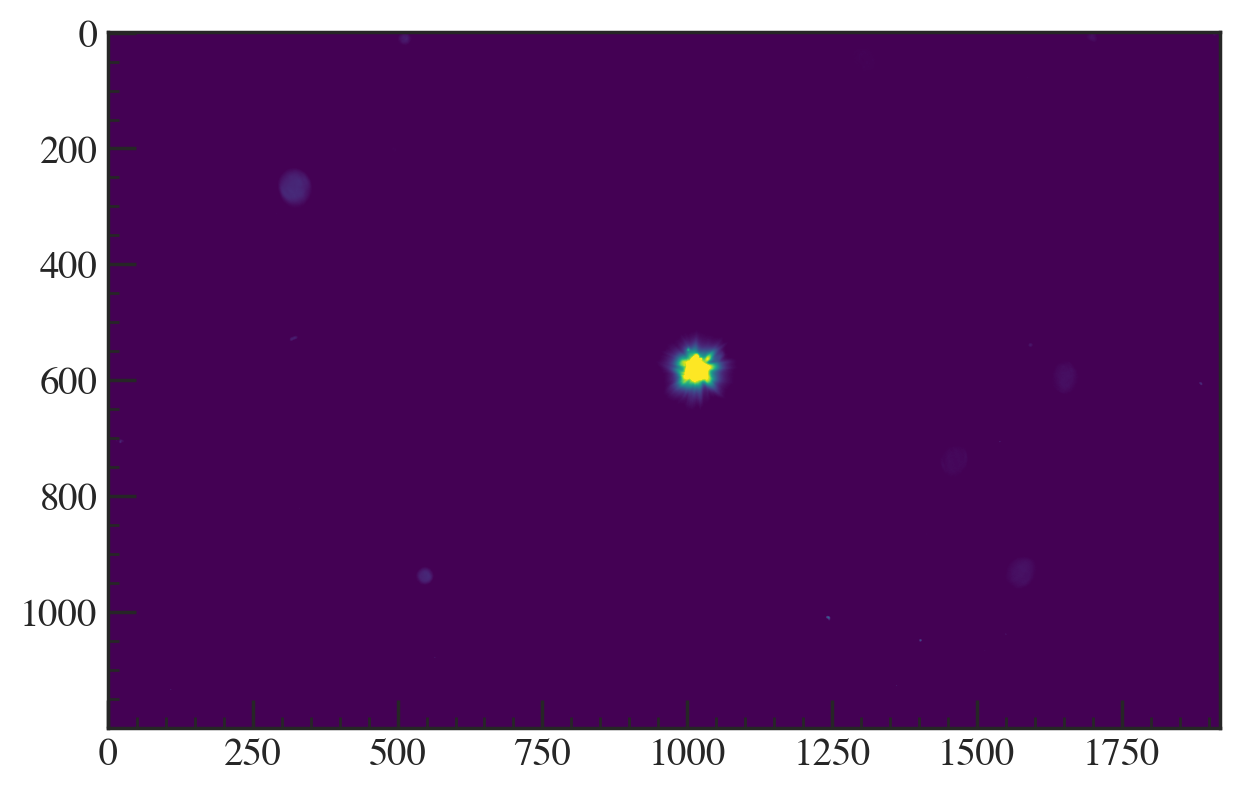

In [39]:
plt.imshow(im_arrayYFPPos0_bs[99], vmin = 1000, vmax = 20000)

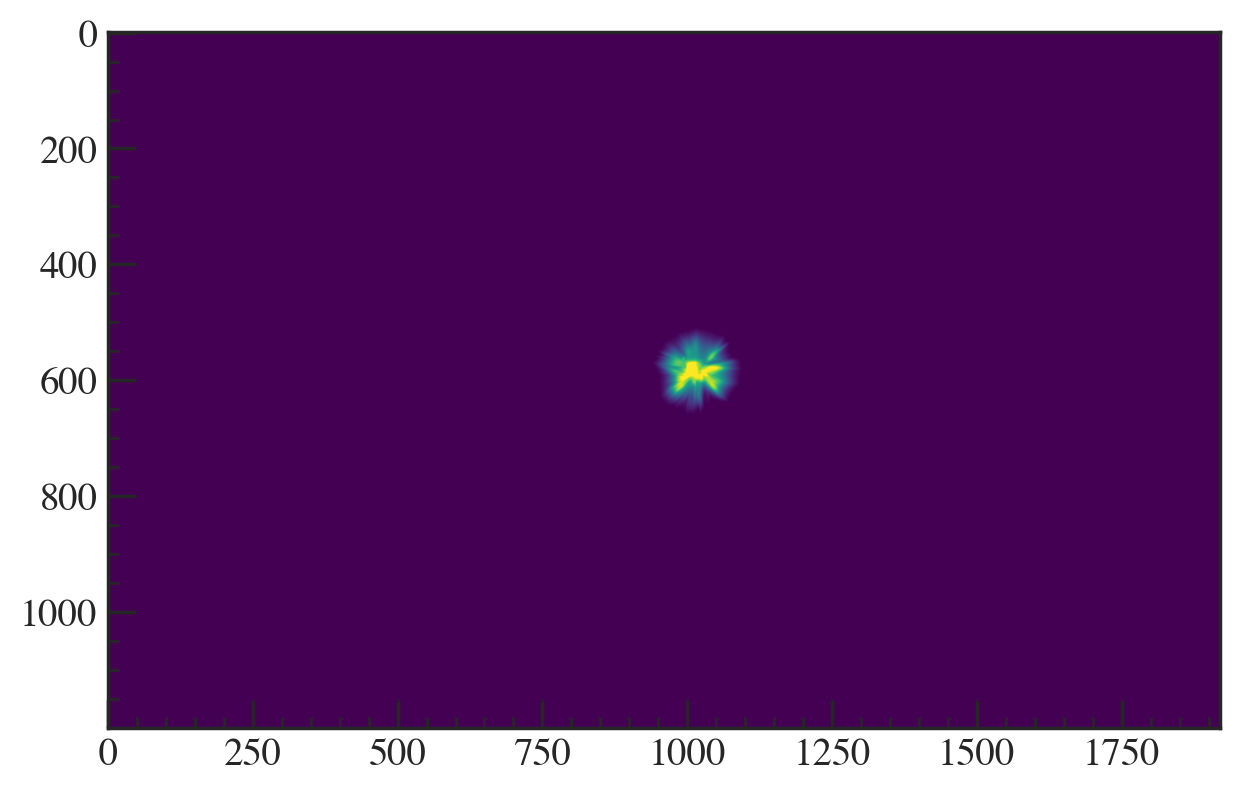

In [40]:
plt.imshow(im_arrayBrightPos0_bs[99], vmin = 1000, vmax = 20000)

### Defining Crops

In [41]:
#set crop pixel values
tc_ymin, tc_ymax, tc_xmin, tc_xmax = 475, 655, 870, 1040 #for 'tight crop'
#define crop window
tight_crop = np.s_[tc_ymin:tc_ymax, tc_xmin:tc_xmax]

#set crop pixel values
wc_ymin, wc_ymax, wc_xmin, wc_xmax = 515, 615, 900, 1010  #for 'tight crop'
#define crop window
wide_crop = np.s_[wc_ymin:wc_ymax, wc_xmin:wc_xmax]

c_ymin, c_ymax, c_xmin, c_xmax = 100, 900, 700, 1500
# define crop window
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

Find the center for each image

### Finding Center of Square

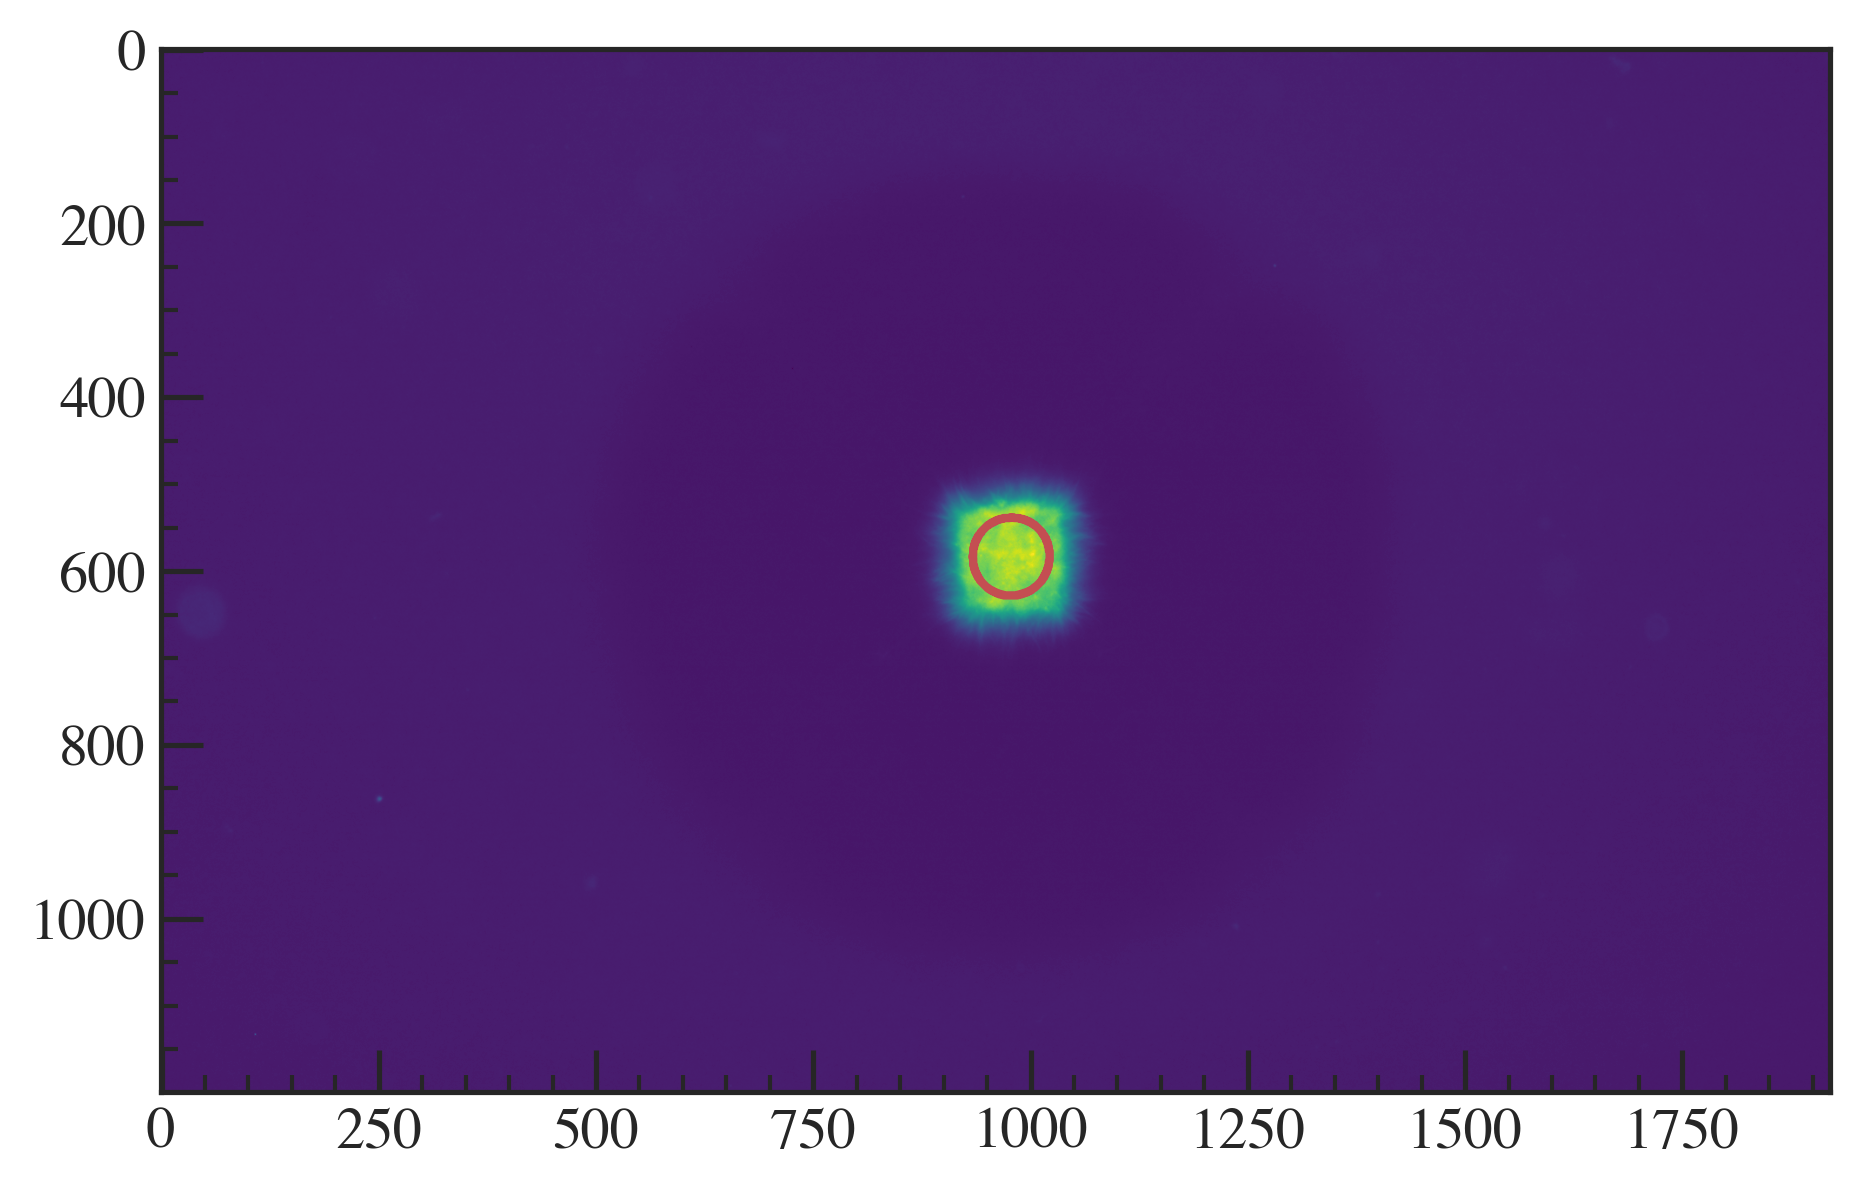

In [42]:
# testing for single image
im = im_arrayBrightPos0_bs[30]

im_gaussian = gaussian(im[crop], sigma=50)
thresh = np.percentile(im_gaussian, 99)
binary = (im_gaussian>thresh).astype(np.uint8)

#create a contour
contours, hierarchy = cv2.findContours(binary, 1, 2)
contours = np.array(contours)
contours[:,:,0,0] += c_xmin
contours[:,:,0,1] += c_ymin
contours = np.squeeze(contours)

fig, ax = plt.subplots(dpi = 300)
ax.imshow(im)
ax.plot(contours[:,0],contours[:,1],'r-')


Find what the center vcalues are for full sized image

In [48]:
def find_centers(array):
    #init empty lists for center vals, radius, frame #

    # min area thresh for contour (IN PIXELS)
    area_thresh = 1000

    centers_tc = []
    radii = []
    frame_num = []
    contours_plot = []

    # min area thresh for contour (IN PIXELS)
    area_thresh = 1000

    centers_tc = []
    radii = []
    frame_num = []
    contours_plot = []

    #for loop thru MT images
    for i, im in enumerate(array):
        #crop image for center identification
        print(i, end = '\r')
        #gaussian blur
        dst = gaussian(im[crop], sigma=50)
        thresh = threshold_otsu(dst)
        #thresh = np.percentile(dst, 99)

        binary = (dst>thresh).astype(np.uint8)

        #create a contour
        contours, hierarchy = cv2.findContours(binary, 1, 2)

        #iterate through contours (for most connected region)
        max_area = 0
        max_index = None

        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_index = j

        if max_area >= area_thresh:
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x + c_xmin, y + c_ymin])
            radii.append(radius)
            frame_num.append(i)

            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            cnt[:,0] += c_xmin
            cnt[:,1] += c_ymin
            contours_plot.append(cnt)

        else:
            print("**CENTER NOT FOUND**")
            cnt = contours[max_index]
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            centers_tc.append([x + c_xmin, y + c_ymin])
            radii.append(radius)        
            cnt = np.array(cnt)
            cnt = np.squeeze(cnt)
            cnt[:,0] += c_xmin
            cnt[:,1] += c_ymin
            contours_plot.append(cnt)

    centers_tc = np.array(centers_tc)
    radii = np.array(radii)
    frame_num = np.array(frame_num)
    return centers_tc, frame_num

centers_tc_Pos0, f_Pos0 = find_centers(im_arrayBrightPos0_bs)
centers_tc_Pos1, f_Pos1 = find_centers(im_arrayBrightPos1_bs)
centers_tc_Pos2, f_Pos2 = find_centers(im_arrayBrightPos2_bs)

In [49]:
def centers_to_int(centers_tc):   
    centers = []
    for center in centers_tc:
        center_x = int(center[0])
        center_y = int(center[1])
        centers.append([center_x, center_y])
    centers = np.array(centers)
    return centers

centers_Pos0 = centers_to_int(centers_tc_Pos0)
centers_Pos1 = centers_to_int(centers_tc_Pos1)
centers_Pos2 = centers_to_int(centers_tc_Pos2)

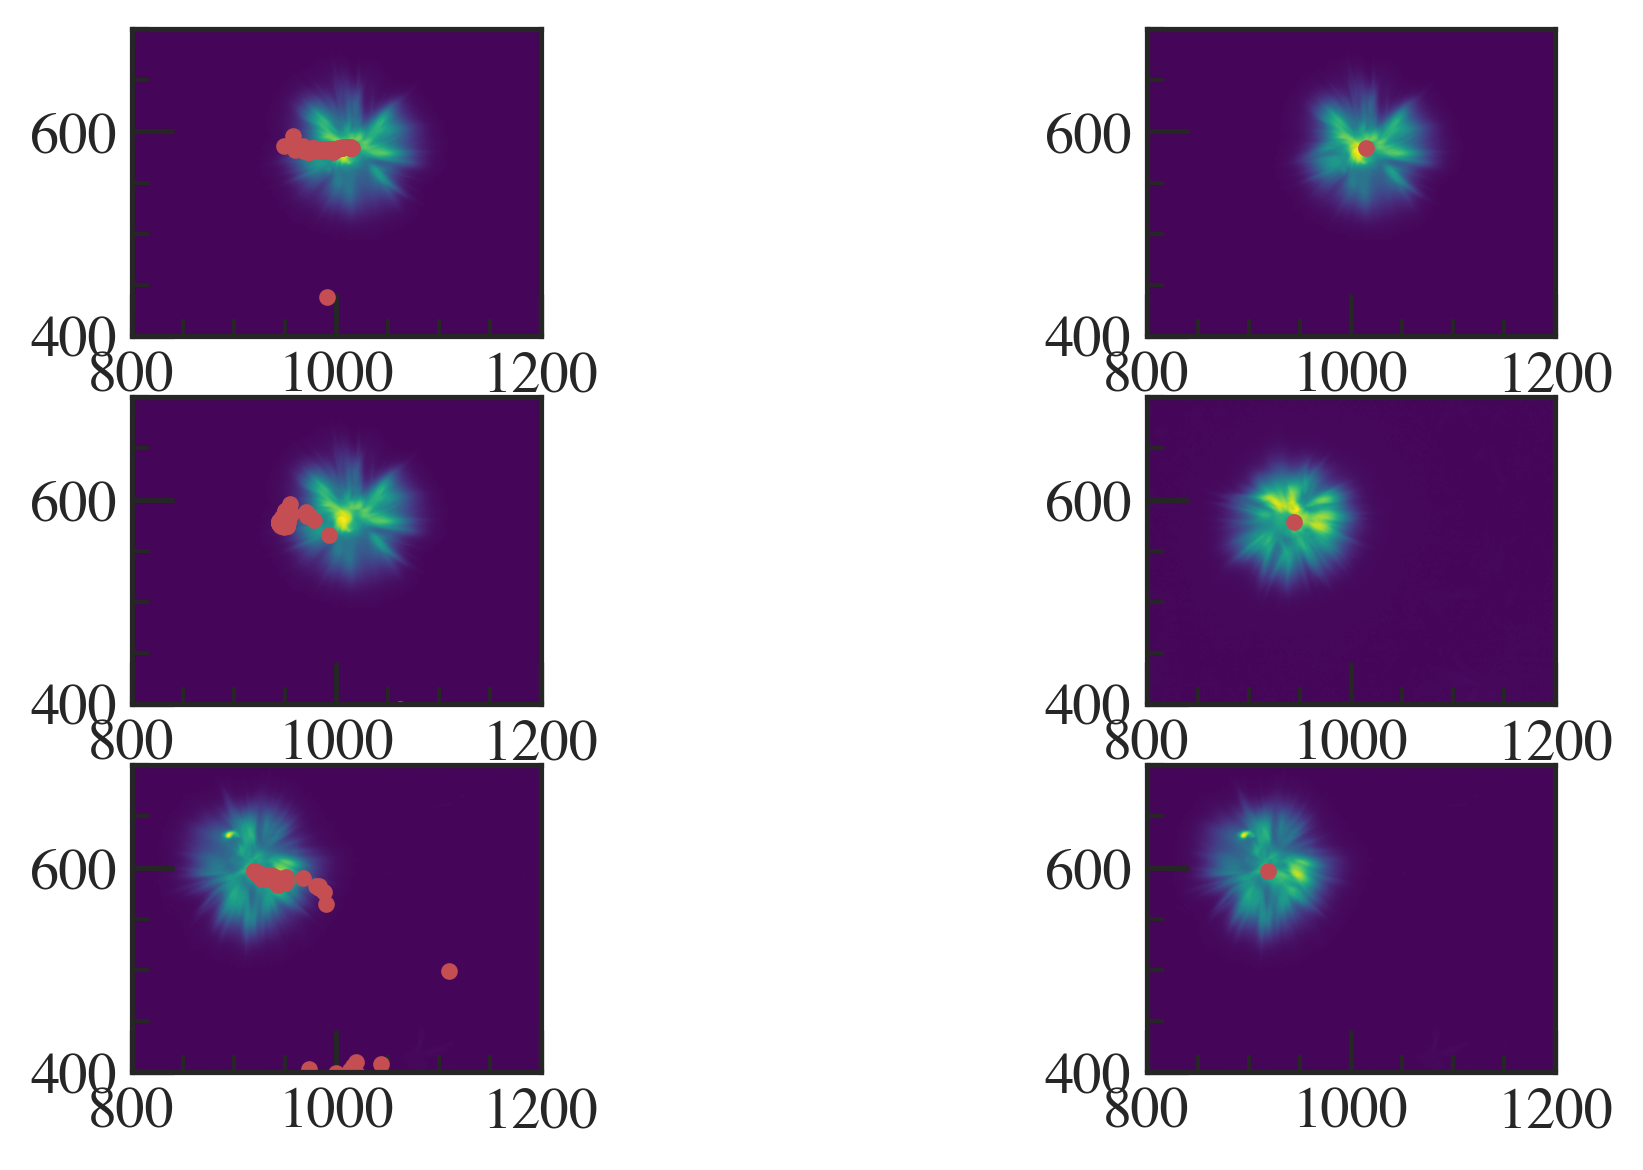

In [53]:
#TEST: plotting all centers
fig, axs = plt.subplots(3,2, dpi=300)

axs[0,0].plot(centers_Pos0[:, 0], centers_Pos0[:, 1], '.r')
axs[0,0].imshow(im_arrayBrightPos0_bs[99])
axs[0,0].set(xlim = (800, 1200),ylim = (400, 700));

index = 99
axs[0,1].imshow(im_arrayBrightPos0_bs[index])
axs[0,1].plot(centers_Pos0[index,0], centers_Pos0[index,1], '.r')
axs[0,1].set(xlim = (800, 1200),ylim = (400, 700));



axs[1,0].plot(centers_Pos1[:, 0], centers_Pos1[:, 1], '.r')
axs[1,0].imshow(im_arrayBrightPos0_bs[99])
axs[1,0].set(xlim = (800, 1200),ylim = (400, 700));

index = 99
axs[1,1].imshow(im_arrayBrightPos1_bs[index])
axs[1,1].plot(centers_Pos1[index,0], centers_Pos1[index,1], '.r')
axs[1,1].set(xlim = (800, 1200),ylim = (400, 700));



axs[2,0].plot(centers_Pos2[:, 0], centers_Pos2[:, 1], '.r')
axs[2,0].imshow(im_arrayBrightPos2_bs[98])
axs[2,0].set(xlim = (800, 1200),ylim = (400, 700));

index = 98
axs[2,1].imshow(im_arrayBrightPos2_bs[index])
axs[2,1].plot(centers_Pos2[index,0], centers_Pos2[index,1], '.r')
axs[2,1].set(xlim = (800, 1200),ylim = (400, 700));

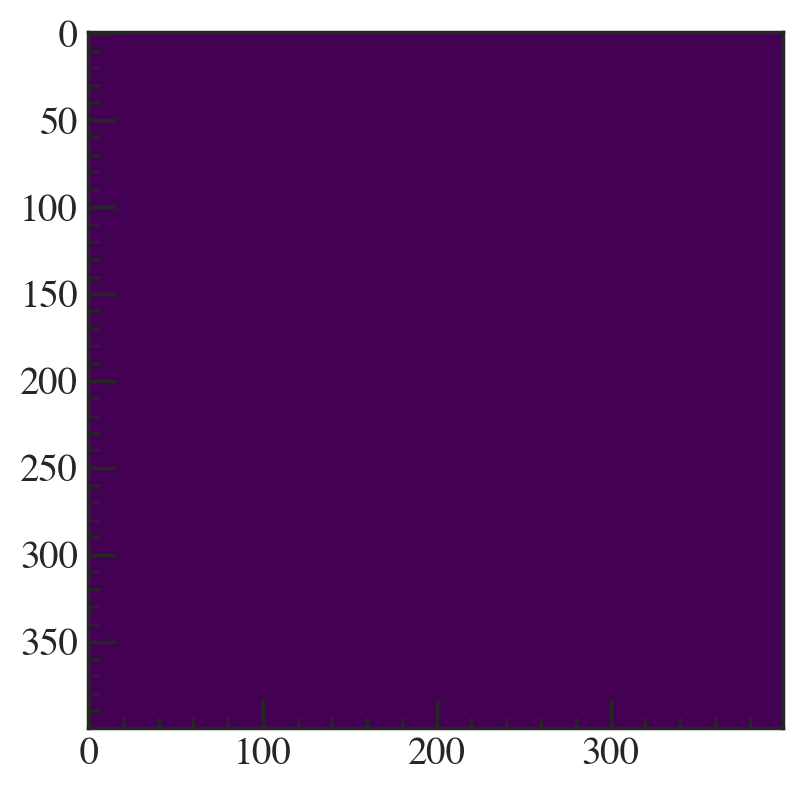

In [55]:
file_path = '../../data/aster'
file_folder = '2022-07-29_Squaster_NCD_Venus_R3_1'

def make_centered_tiff(array, centers, filename):
    crops = []
    length = 200
    for i in range(len(array)):
        crops.append(np.s_[centers[i][1]-length:centers[i][1]+length, centers[i][0]-length:centers[i][0]+length])
    array_cropped = np.array([array[i][crops[i]] for i in range(len(array))])
    plt.imshow(array_cropped[len(array)-1], vmin=0, vmax=200000)
    array_cropped = [Image.fromarray(im) for im in array_cropped[1:]]
    array_cropped[0].save(filename, save_all=True, append_images=array_cropped[1:])
    
make_centered_tiff(im_arrayBrightPos0_bs, centers_Pos0, file_path+'/'+file_folder+'/bright_pos0.tiff')
make_centered_tiff(im_arrayYFPPos0_bs, centers_Pos0, file_path+'/'+file_folder+'/YFP_pos0.tiff')
make_centered_tiff(im_arrayBrightPos1_bs, centers_Pos1, file_path+'/'+file_folder+'/bright_pos1.tiff')
make_centered_tiff(im_arrayYFPPos1_bs, centers_Pos1, file_path+'/'+file_folder+'/YFP_pos1.tiff')
make_centered_tiff(im_arrayBrightPos2_bs, centers_Pos2, file_path+'/'+file_folder+'/bright_pos2.tiff')
make_centered_tiff(im_arrayYFPPos2_bs, centers_Pos2, file_path+'/'+file_folder+'/YFP_pos2.tiff')

### Plotting analysis

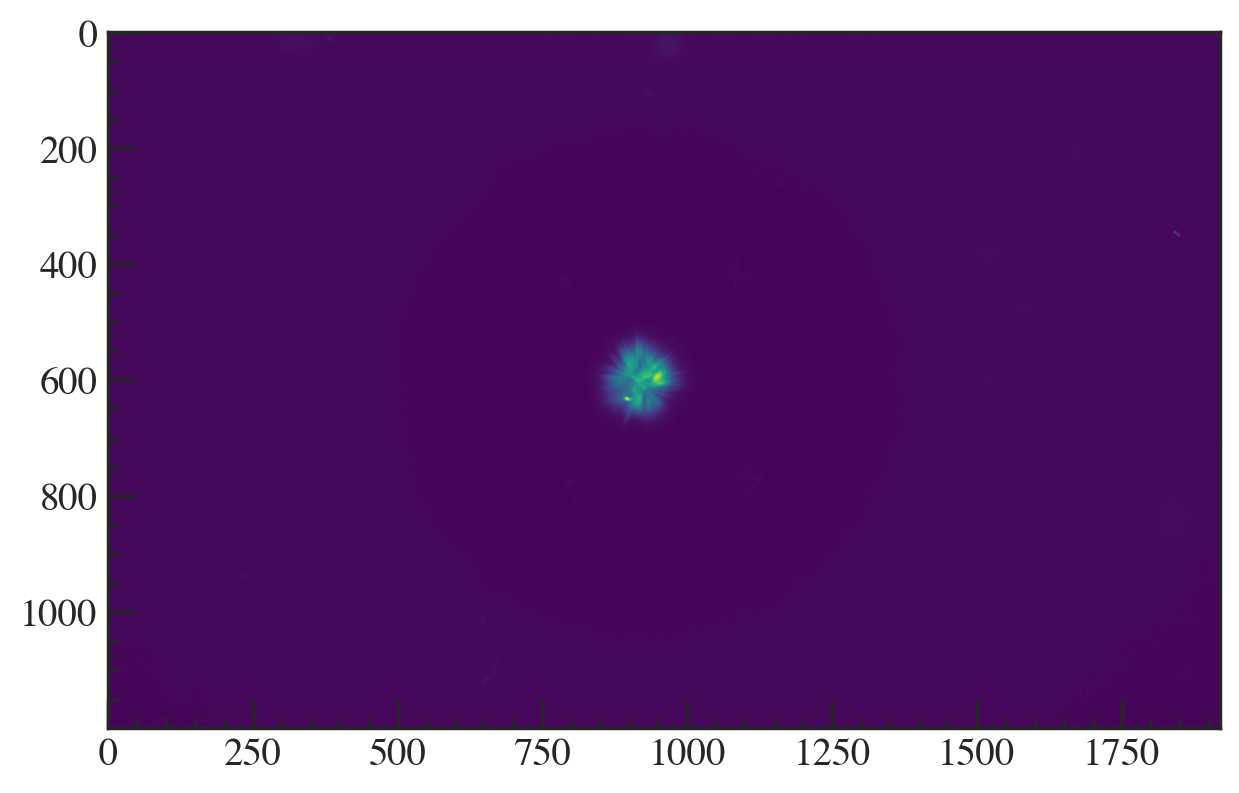

In [74]:
im_arrayBrightPos0_bs
im_arrayYFPPos0_bs
centers_Pos0
im_arrayBrightPos1_bs
im_arrayYFPPos1_bs
centers_Pos1
im_arrayBrightPos2_bs
im_arrayYFPPos2_bs
centers_Pos2

plt.imshow(im_arrayBrightPos2_bs[98])

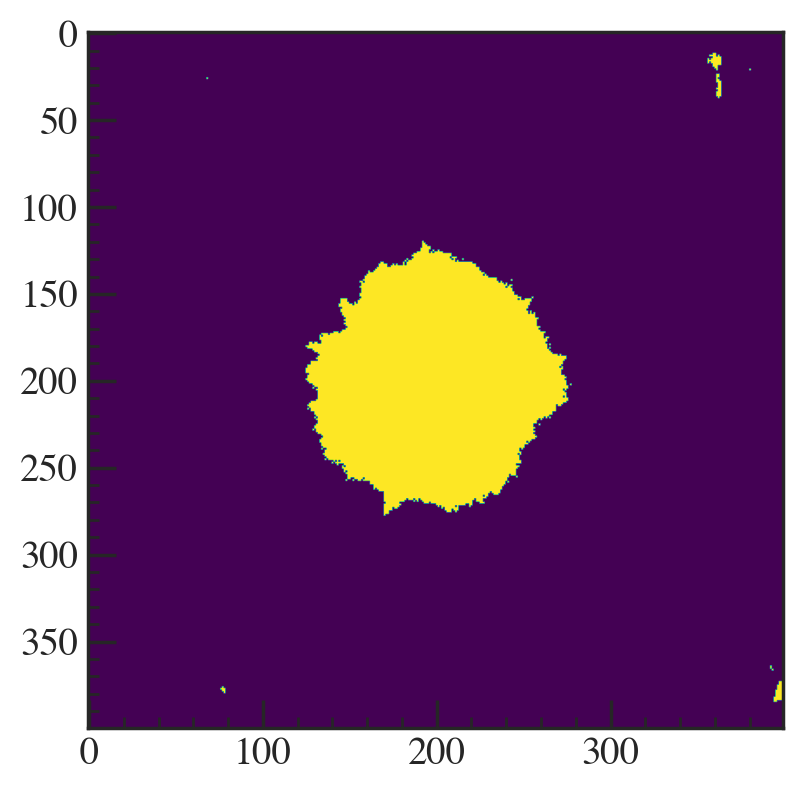

In [79]:
# how circular is our distribution?

def how_square(array, centers, filename):
    crops = []
    length = 200
    for i in range(len(array)):
        crops.append(np.s_[centers[i][1]-length:centers[i][1]+length, centers[i][0]-length:centers[i][0]+length])
    array_cropped = np.array([array[i][crops[i]] for i in range(len(array))])
    array_cropped_thresh = np.array([np.percentile(array_cropped[i], 90) for i in range(len(array_cropped))])
    binary = np.array([(array_cropped[i]>array_cropped_thresh[i]).astype(np.uint8) for i in range(len(array_cropped_thresh))])
    plt.imshow(binary[len(array)-2], vmin=0, vmax=1)
    binary = [Image.fromarray(im) for im in binary[1:]]
    binary[0].save(filename, save_all=True, append_images=binary[1:])

how_square(im_arrayBrightPos0_bs, centers_Pos0, file_path+'/'+file_folder+'/bright_pos0_bin.tiff')
how_square(im_arrayYFPPos0_bs, centers_Pos0, file_path+'/'+file_folder+'/YFP_pos0_bin.tiff')
how_square(im_arrayBrightPos1_bs, centers_Pos1, file_path+'/'+file_folder+'/bright_pos1_bin.tiff')
how_square(im_arrayYFPPos1_bs, centers_Pos1, file_path+'/'+file_folder+'/YFP_pos1_bin.tiff')
how_square(im_arrayBrightPos2_bs, centers_Pos2, file_path+'/'+file_folder+'/bright_pos2_bin.tiff')
how_square(im_arrayYFPPos2_bs, centers_Pos2, file_path+'/'+file_folder+'/YFP_pos2_bin.tiff')